In [1]:
# !pip install -U matplotlib --quiet
# !pip install torch --quiet
# !pip install lightning --quiet

In [2]:
# !git clone https://github.com/QMCSoftware/QMCSoftware
# !cd QMCSoftware && git checkout qmctoolscl_integration
# !cd QMCSoftware && git pull
# !cd QMCSoftware && pip install -e .

# CHONKNORIS for a 1 dimensional Burgers equation

Here we will solve the PDE

$$\begin{cases} \partial_t v + v \partial_x v - \nu \partial_x^2 v = 0, & (x,t) \in (0,1) \times (0,1] \\ v(x,0) = u(x), & x \in (0,1) \\ v(0,t) = v(1,t) = 0, & t \in [0,1]\end{cases}$$

In [3]:
import os
os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1' # cholesky not implemented on MPS, fall back to CPU
import torch

In [4]:
# may need to Runtime > Restart session if loading for the first time on Google Colab
import torch
import qmcpy as qp
import pandas as pd
import numpy as np
import lightning
import time
from collections import OrderedDict
import os
import glob
import warnings
from typing import List

In [5]:
ROOT = "."
assert os.path.isfile(ROOT+"/burgers_1d.ipynb")

In [6]:
assert torch.cuda.is_available() or torch.backends.mps.is_available()
DEVICE = "cuda" if torch.cuda.is_available() else "mps"
DEVICE

'cuda'

In [7]:
from matplotlib import pyplot,cm,colors,gridspec
#print(pyplot.style.available)
pyplot.style.use('seaborn-v0_8-whitegrid') 
LW = 3 # linewidth
LWTHIN = 0.01
COLORS = ["xkcd:"+color[:-1] for color in pd.read_csv("../../xkcd_colors.txt",comment="#").iloc[:,0].tolist()]

## Reference Solution

Using the [Cole-Hopf transform](https://www.iist.ac.in/sites/default/files/people/IN08026/Burgers_equation_viscous.pdf) we have that 
$$v(x,t) = \frac{\int_{-\infty}^\infty f(\eta) \frac{x-\eta}{t} \exp\left(-\frac{(x-\eta)^2}{4 \nu t}\right) \mathrm{d} \eta}{\int_{-\infty}^\infty f(\eta) \exp\left(-\frac{(x-\eta)^2}{4 \nu t}\right) \mathrm{d} \eta}$$
where $f(x) = \exp\left(-\frac{1}{2\nu} \int_0^x u(y) \mathrm{d} y\right)$. 

We will randomly generate
$$u(x)  = \sum_{k=1}^P a_k \sin (k \pi x)$$
where $a_1,\dots,a_P \overset{\mathrm{IID}}{\sim} \mathcal{N}(0,1)$.
This gives
$$f(x) = \exp\left(-\sum_{k=1}^P \frac{a_k}{2 \nu \pi k} [\cos(\pi k)-\cos(\pi k x)]\right)$$

We use [Gauss-Hermite quadrature](https://en.wikipedia.org/wiki/Gauss%E2%80%93Hermite_quadrature) to numerically approximate the two integrals. To do so, we make the change of variables $z = (x-\eta)/\sqrt{4 \nu t}$ we have $\eta=x-\sqrt{4 \nu t}z$ and $\partial \eta/\partial z = -\sqrt{4 \nu t}$ so 
$$v(x,t) = \sqrt{4 \nu} \frac{\int_{-\infty}^\infty f(x-\sqrt{4 \nu t}z) \frac{z}{\sqrt{t}} \exp\left(-z^2\right) \mathrm{d} z}{\int_{-\infty}^\infty f(x-\sqrt{4 \nu t}z) \exp\left(-z^2\right) \mathrm{d} z}$$


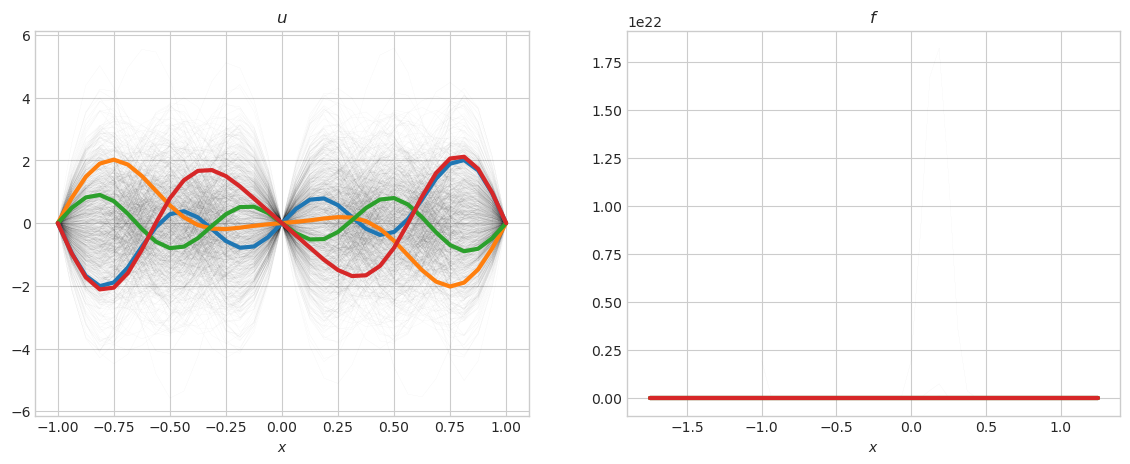

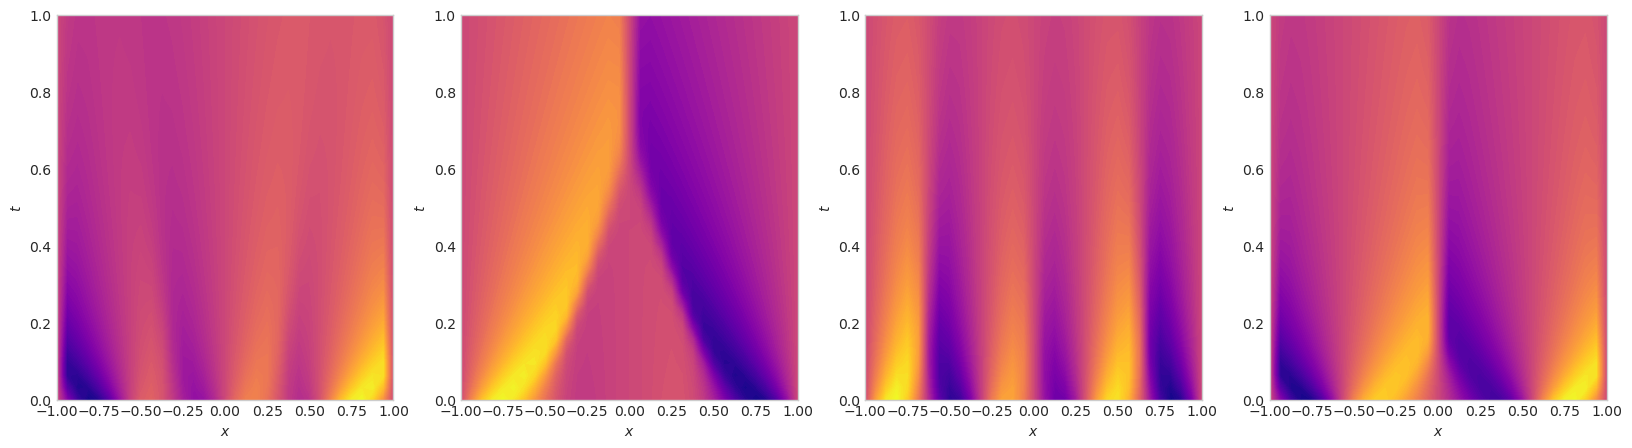

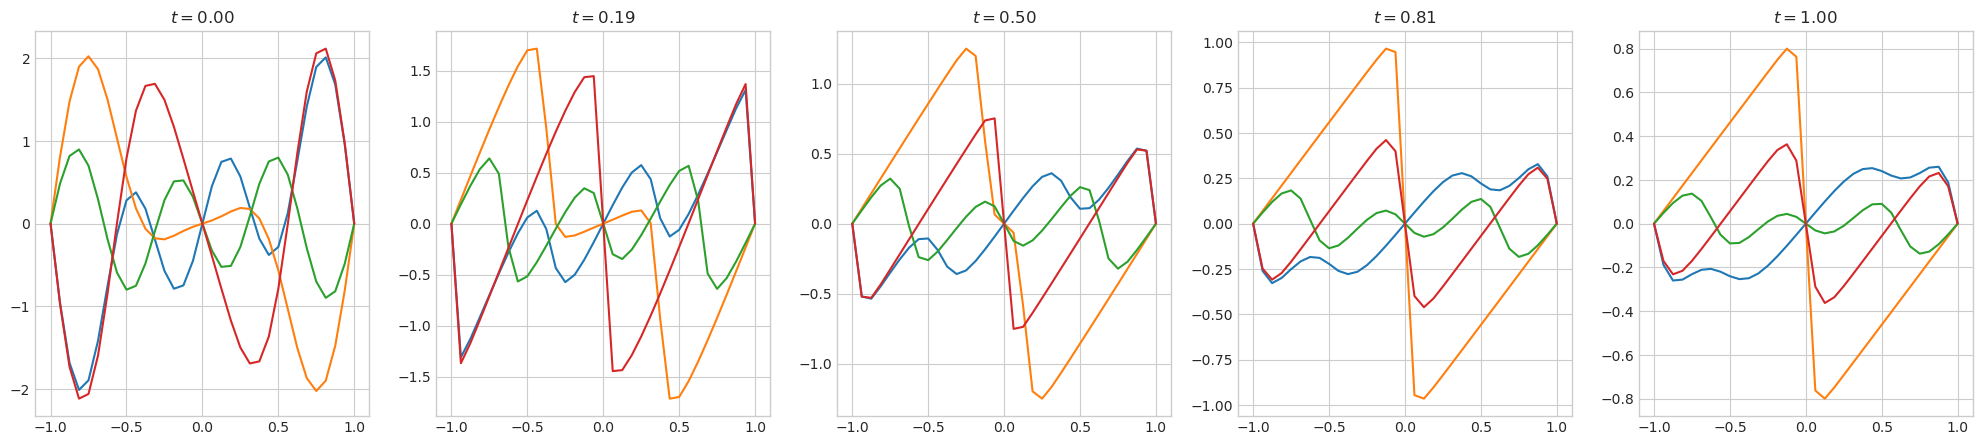

In [8]:
NU = 0.02
P = 3
R = 2**10
GHDEG = 350
nxticks = 33
ntticks = 33
nticks = nxticks*ntticks
xticks = torch.linspace(-1,1,nxticks,device="cpu",dtype=torch.float64)
tticks = torch.linspace(0,1,ntticks,device="cpu",dtype=torch.float64)
xmesh,tmesh = torch.meshgrid(xticks,tticks,indexing="ij")
ticks = torch.vstack([xmesh.flatten(),tmesh.flatten()]).T
a = torch.from_numpy(qp.Gaussian(qp.DigitalNetB2(P,seed=7)).gen_samples(R)).to("cpu")
k = torch.arange(1,P+1,device="cpu")
def u_func(x):
    y = a[:,:,None]*torch.sin(torch.pi*k[:,None]*x)
    return y.sum(1)
u = u_func(xticks) 
def f_func(x):
    y = -1/(2*NU*torch.pi*k[:,None])*a[:,:,None]*(torch.cos(torch.pi*k[:,None])-torch.cos(k[:,None]*torch.pi*x))
    return torch.exp(y.sum(1))
gh_pts,gh_weights = np.polynomial.hermite.hermgauss(GHDEG) 
gh_pts,gh_weights = torch.from_numpy(gh_pts).to("cpu"),torch.from_numpy(gh_weights).to("cpu")
etamesh = xmesh[:,:,None]-torch.sqrt(4*NU*tmesh[:,:,None])*gh_pts
fmesh = f_func(etamesh.flatten()).reshape((-1,*etamesh.shape))
denom = (fmesh*gh_weights).sum(-1)
numer = (fmesh*gh_pts/torch.sqrt(tmesh[:,:,None])*gh_weights).sum(-1)
vticks = np.sqrt(4*NU)*numer/denom
vticks[:,:,0] = u
plt_highlights = 4
fig,ax = pyplot.subplots(nrows=1,ncols=2,figsize=(14,5))
ax[0].set_title(r"$u$")
ax[0].set_xlabel(r"$x$")
ax[0].plot(xticks,u.T,linewidth=LWTHIN,color="k")
ax[0].plot(xticks,u[:plt_highlights].T,linewidth=LW)
xticks_ext = xticks*1.5-.25
f = f_func(xticks_ext)
ax[1].set_title(r"$f$")
ax[1].set_xlabel(r"$x$")
ax[1].plot(xticks,f.T,linewidth=LWTHIN,color="k")
ax[1].plot(xticks_ext,f[:plt_highlights].T,linewidth=LW);
#ax[1].set_ylim([0,5])
fig.show()
fig,ax = pyplot.subplots(nrows=1,ncols=plt_highlights,figsize=(5*plt_highlights,5))
for i in range(plt_highlights):
    ax[i].contourf(xmesh,tmesh,vticks[i],cmap=cm.plasma,levels=100)
    ax[i].set_xlabel(r"$x$"); ax[i].set_ylabel(r"$t$")
fig.show()
tpltidxs = [0,ntticks//5,ntticks//2,4*ntticks//5,ntticks-1]
fig,ax = pyplot.subplots(nrows=1,ncols=len(tpltidxs),figsize=(5*len(tpltidxs),5))
for i,tiplt in enumerate(tpltidxs):
    ax[i].set_title(r"$t = %.2f$"%tticks[tiplt])
    ax[i].plot(xticks,vticks[:plt_highlights,:,tiplt].T)

## GP for PDE Solves

$$\begin{cases} \partial_t v + v \partial_x v - \nu \partial_x^2 v = 0, & (x,t) \in (0,1) \times (0,1] \\ v(x,0) = u(x), & x \in (0,1) \\ v(0,t) = v(1,t) = 0, & t \in [0,1]\end{cases}$$

In [9]:
llbetas = [ # derivative orders
    [ # interior
        torch.tensor([[0,0]],dtype=int), # v
        torch.tensor([[1,0]],dtype=int), # v_x
        torch.tensor([[0,1],[2,0]],dtype=int), # v_t - \nu v_xx
    ],
    [ # boundary condition
        torch.tensor([[0,0]],dtype=int) # v
    ],
    [ # initial condition
        torch.tensor([[0,0]],dtype=int) # v 
    ]
]
llcs = [ # summand of derivatives coefficients
    [ # interior
        torch.ones(1,dtype=float), # v
        torch.ones(1,dtype=float), # laplacian v
        torch.tensor([1,-NU],dtype=float) # laplacian v
    ],
    [ # boundary condition
        torch.ones(1,dtype=float) # v
    ], 
    [ # initial condition
        torch.ones(1,dtype=float) # v 
    ]
]

ki matrix is 1088 x 1088


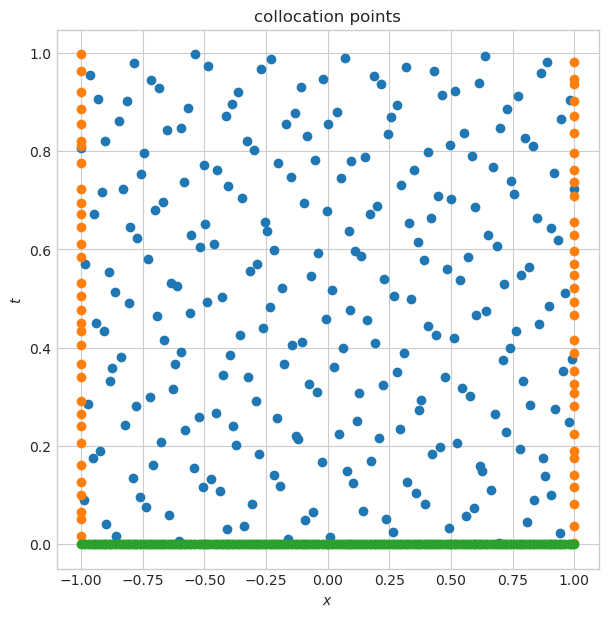

In [26]:
n = 2**8 
noise = 1e-10
sampler = qp.Uniform(qp.DigitalNetB2(dimension=2,seed=11),lower_bound=[-1,0],upper_bound=[1,1]) # collocation points
x_i = torch.from_numpy(sampler.gen_samples(n))
x_bc = x_i[:len(x_i)//4].clone(); x_bc[:len(x_bc)//2,0] = -1; x_bc[len(x_bc)//2:,0] = 1 
x_ic = x_i[:len(x_i)].clone(); x_ic[:,1] = 0
xs = [x_i,x_bc,x_ic]
#kernel = qp.KernelShiftInvar(dimension=1,lengthscales=1e-1,alpha=4,scale=1.,torchify=True) # kernel
kernel = qp.KernelGaussian(dimension=2,scale=1.,torchify=True,lengthscales=torch.tensor([1e-1,2e0]))#[1/200,1/100]))#[1/20**2,1/3**2]))
ki = qp.PDEGramMatrix(kernel,xs,None,None,llbetas,llcs,noise) # kernel interpolant
fig,ax = pyplot.subplots(nrows=1,ncols=1,figsize=(7,7))
ax.scatter(x_i[:,0],x_i[:,1])
ax.scatter(x_bc[:,0],x_bc[:,1])
ax.scatter(x_ic[:,0],x_ic[:,1])
ax.set_xlabel(r"$x$")
ax.set_ylabel(r"$t$")
ax.set_title("collocation points")
print("ki matrix is %d x %d"%(ki.length,ki.length))

iter avg l2rerrs: [1.         0.75856954 0.3406706  0.24574319 0.23662967 0.23407985
 0.23483105]


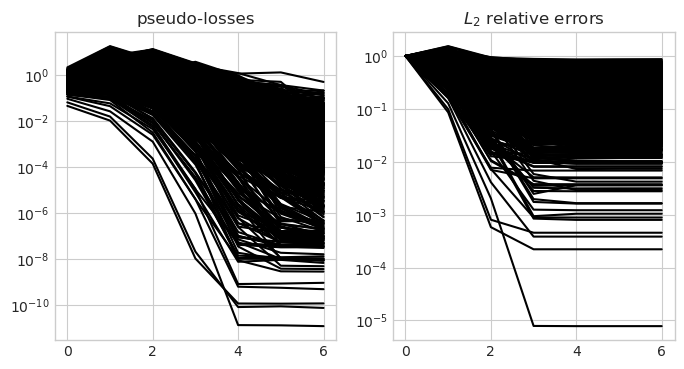

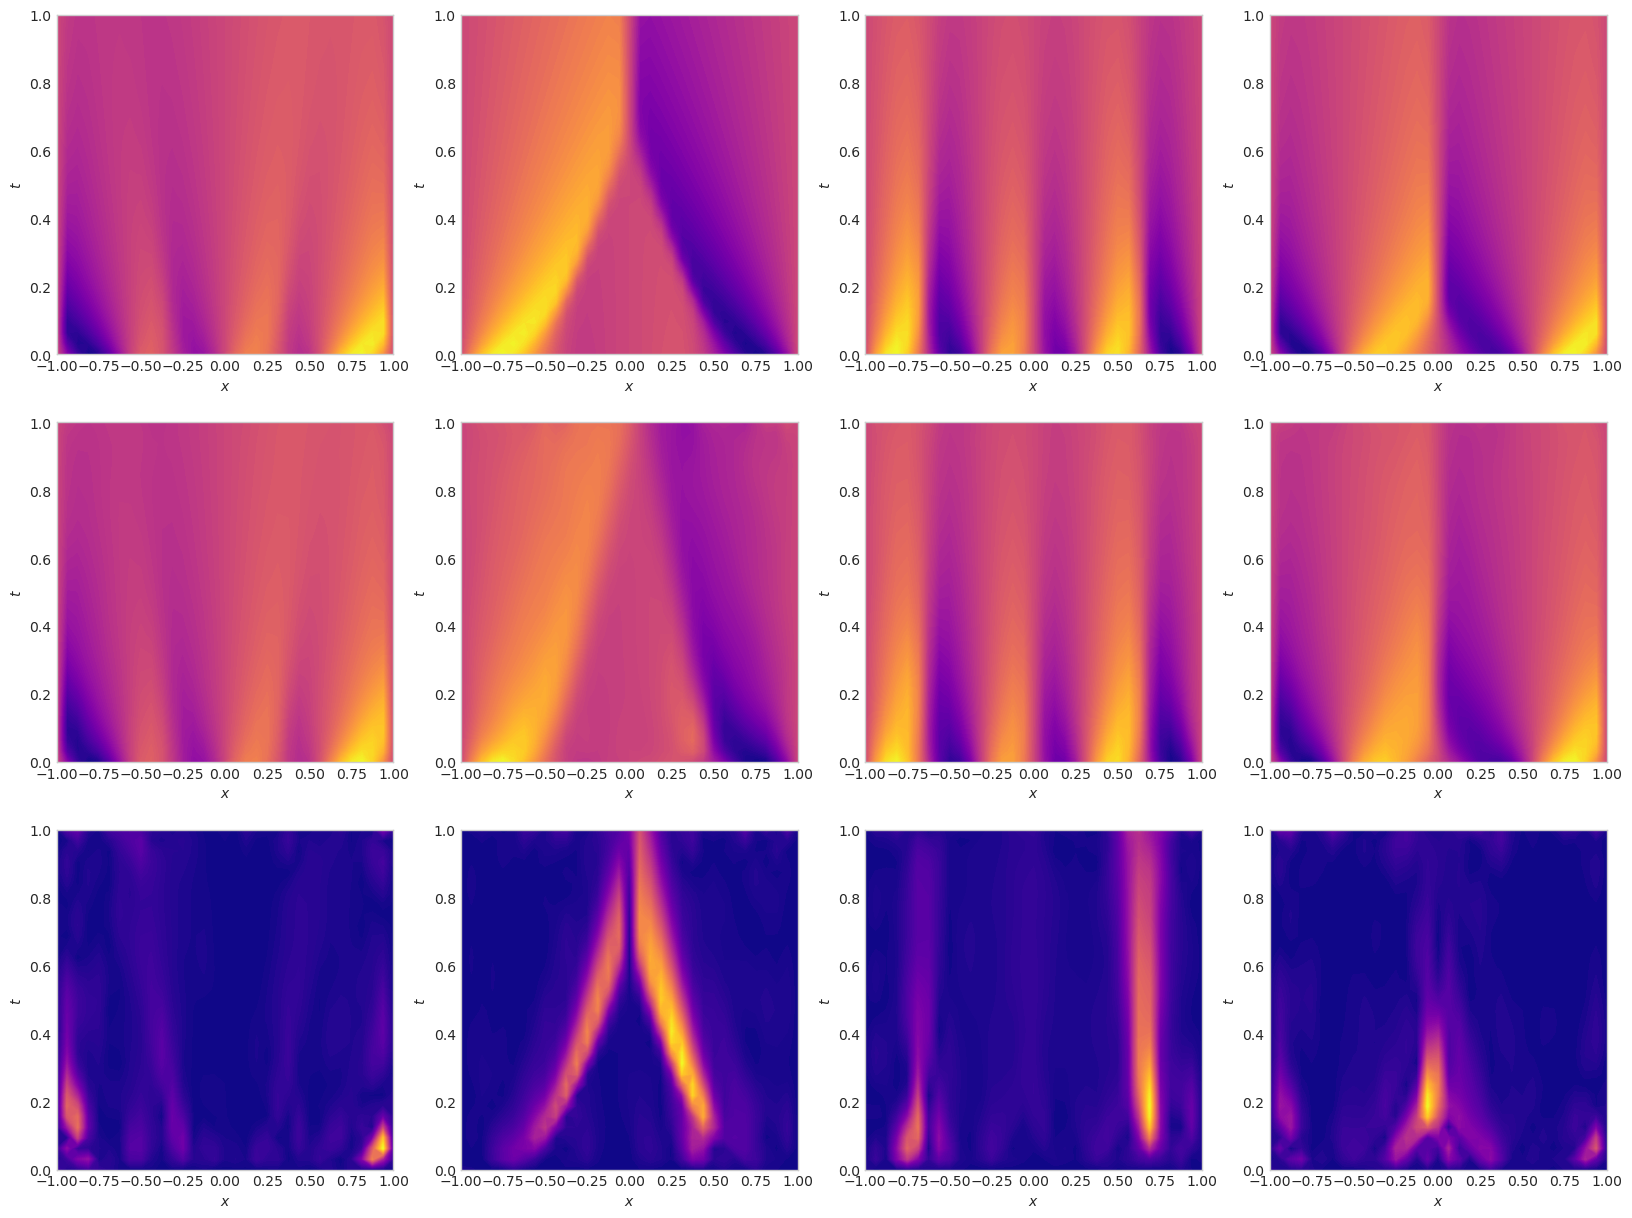

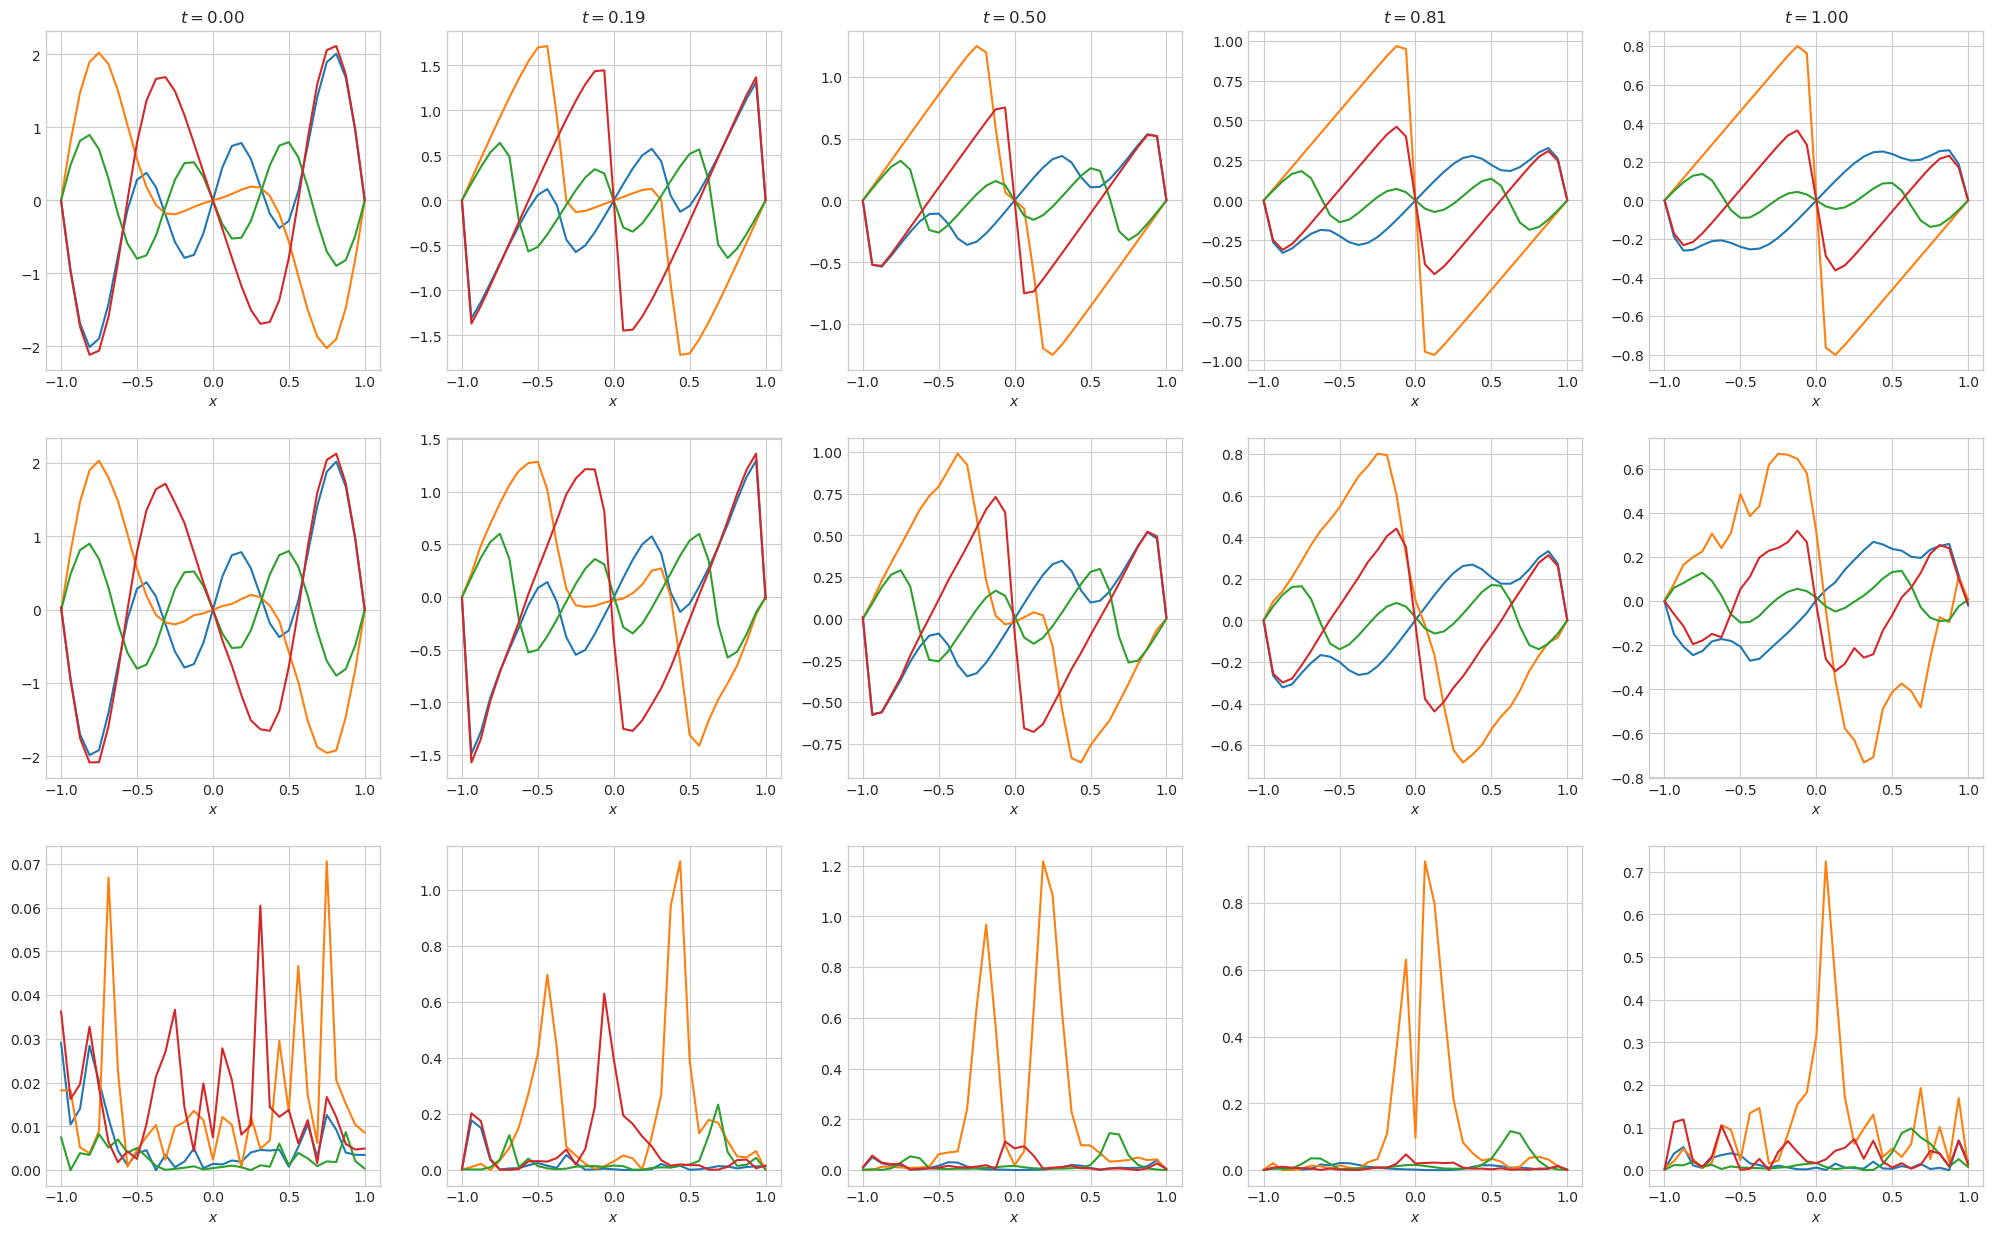

In [12]:
kvec = ki.get_new_left_full_gram_matrix(ticks)
u_ic = u_func(x_ic[:,0])
def get_data(maxiter=10, tag="full", force_gen=False):
    fname = "%s/%s.%s"%(ROOT,"burgers_1d_data",tag)
    _tril_i0,_tril_i1 = torch.tril_indices(ki.ntot,ki.ntot)
    if (not os.path.exists(fname+".npz")) or force_gen:
        data = {
            "vopt": np.empty((R,maxiter+1,ki.length)),
            "losses_opt": np.empty((R,maxiter+1)),
            "vhats": np.empty((R,maxiter+1,nxticks,ntticks)),
            "l2relerrors": np.empty((R,maxiter+1)),
            "L_chols": np.empty((R,maxiter,int(ki.ntot/2*(1+ki.ntot))))}
        print("r from 0 to %d, l2 relative errors\n"%(R)+"~"*100)
        verbosity = max(R//16,1)
        for r in range(R):
            if (r+1)%verbosity==0: print("r = %d: "%(r+1),end='',flush=True)
            def pde_lhs_r(ly_i, ly_bc, ly_ic):
                v_i,v_x_i,v_t_minus_NU_v_xx_i = ly_i
                v_bc = ly_bc[0]
                v_ic = ly_ic[0]
                lhs_i = v_i*v_x_i+v_t_minus_NU_v_xx_i
                lhs_bc = v_bc
                lhs_ic = v_ic
                return lhs_i,lhs_bc,lhs_ic
            def pde_rhs_r(x_i, x_bc, x_ic):
                y_i = torch.zeros(len(x_i),dtype=float)
                y_bc = torch.zeros(len(x_bc),dtype=float)
                y_ic = u_ic[r]
                return y_i,y_bc,y_ic
            y,data_r = ki.pde_opt_gauss_newton(
                pde_lhs = pde_lhs_r,
                pde_rhs = pde_rhs_r,
                maxiter = maxiter,
                store_L_chol_hist = True,
                verbose = False)
            data["vopt"][r] = data_r["zhist"].numpy()
            data["losses_opt"][r] = data_r["losses"].numpy()
            data["vhats"][r] = (kvec@ki._solve(data_r["zhist"].T)).T.reshape((-1,nxticks,ntticks)).numpy()
            data["l2relerrors"][r] = (torch.linalg.norm(torch.from_numpy(data["vhats"][r]).reshape((-1,nticks))-vticks[r].flatten(),dim=1)/torch.linalg.norm(vticks[r].flatten())).numpy()
            data["L_chols"][r] = data_r["L_chol_hist"][:,_tril_i0,_tril_i1].numpy()
            if (r+1)%verbosity==0:
                with np.printoptions(formatter={"float":lambda x: "%.1e"%x}):
                    print(data["l2relerrors"][r])        
        np.savez_compressed(fname,**data)
    data = np.load(fname+".npz")
    L_chols = torch.empty((R,maxiter,ki.ntot,ki.ntot),dtype=torch.float64)
    L_chols[:,:,_tril_i0,_tril_i1] = torch.from_numpy(data["L_chols"])
    return (
        torch.from_numpy(data["vopt"]),
        torch.from_numpy(data["losses_opt"]),
        torch.from_numpy(data["vhats"]),
        torch.from_numpy(data["l2relerrors"]),
        L_chols)
maxiter = 6
vopt,losses_opt,vhats,l2rerrs,L_chols = get_data(maxiter=maxiter,tag="small",force_gen=False)
print("iter avg l2rerrs:",l2rerrs.mean(0).numpy())
best_idxs = losses_opt.argmin(1)
vopt_best = vopt[np.arange(R),best_idxs,:]
if True:
    fig,ax = pyplot.subplots(nrows=1,ncols=2,figsize=(8,4))
    ax[0].set_title("pseudo-losses")
    ax[0].plot(torch.arange(losses_opt.size(1)),losses_opt.T,color="k")#,linewidth=LWTHIN)
    ax[0].set_yscale("log",base=10)
    ax[1].set_title(r"$L_2$ relative errors")
    ax[1].plot(torch.arange(l2rerrs.size(1)),l2rerrs.T,color="k")#,linewidth=LWTHIN)
    ax[1].set_yscale("log",base=10)
    fig.show()
    fig,ax = pyplot.subplots(nrows=3,ncols=plt_highlights,figsize=(5*plt_highlights,5*3))
    for i in range(plt_highlights):
        ax[0,i].contourf(xmesh,tmesh,vticks[i],cmap=cm.plasma,levels=100)
        ax[1,i].contourf(xmesh,tmesh,vhats[i,-1],cmap=cm.plasma,levels=100)
        ax[2,i].contourf(xmesh,tmesh,torch.abs(vticks[i]-vhats[i,-1]),cmap=cm.plasma,levels=100)
        for l in range(3): ax[l,i].set_xlabel(r"$x$"); ax[l,i].set_ylabel(r"$t$")
    fig.show()
    tpltidxs = [0,ntticks//5,ntticks//2,4*ntticks//5,ntticks-1]
    fig,ax = pyplot.subplots(nrows=3,ncols=len(tpltidxs),figsize=(5*len(tpltidxs),5*3))
    for i,tiplt in enumerate(tpltidxs):
        ax[0,i].set_title(r"$t = %.2f$"%tticks[tiplt])
        ax[0,i].plot(xticks,vticks[:plt_highlights,:,tiplt].T)
        ax[1,i].plot(xticks,vhats[:plt_highlights,-1,:,tiplt].T)
        ax[2,i].plot(xticks,torch.abs(vticks[:plt_highlights,:,tiplt]-vhats[:plt_highlights,-1,:,tiplt]).T)
        for l in range(3):
            ax[l,i].set_xlabel(r"$x$")

## Training and Validation Dataloaders

In [14]:
def train_val_split(R, to_split, val_frac=1/8, shuffle=False, rng_shuffle_seed=None):
    if shuffle:
        rng = np.random.Generator(np.random.PCG64(rng_shuffle_seed))
        tv_idx = torch.from_numpy(rng.permutation(R))
    else:
        tv_idx = torch.arange(R)
    n_train = R-int(val_frac*R)
    n_val = R-n_train
    tidx = tv_idx[:n_train]
    vidx = tv_idx[n_train:]
    splits = (vval for val in to_split for vval in (val[tidx],val[vidx]))
    return splits 
(u_ic_train,u_ic_val,
 vticks_train,vticks_val,
 vopt_train,vopt_val,
 vhats_train,vhats_val,
 l2rerrs_train,l2rerrs_val,
 L_chols_train,L_chols_val) = train_val_split(R,[u_ic,vticks,vopt,vhats,l2rerrs,L_chols],shuffle=True)
print("u_ic_train.shape:",tuple(u_ic_train.shape))
print("vticks_train.shape:",tuple(vticks_train.shape))
print("vopt_train.shape:",tuple(vopt_train.shape))
print("vticks_train.shape:",tuple(vticks_train.shape))
print("vhats_train.shape:",tuple(vhats_train.shape))
print("l2rerrs_train.shape:",tuple(l2rerrs_train.shape))
print("L_chols_train.shape:",tuple(L_chols_train.shape))
print()
print("u_ic_val.shape:",tuple(u_ic_val.shape))
print("vticks_val.shape:",tuple(vticks_val.shape))
print("vopt_val.shape:",tuple(vopt_val.shape))
print("vticks_val.shape:",tuple(vticks_val.shape))
print("vhats_val.shape:",tuple(vhats_val.shape))
print("l2rerrs_val.shape:",tuple(l2rerrs_val.shape))
print("L_chols_val.shape:",tuple(L_chols_val.shape))

u_ic_train.shape: (896, 256)
vticks_train.shape: (896, 33, 33)
vopt_train.shape: (896, 7, 1088)
vticks_train.shape: (896, 33, 33)
vhats_train.shape: (896, 7, 33, 33)
l2rerrs_train.shape: (896, 7)
L_chols_train.shape: (896, 6, 576, 576)

u_ic_val.shape: (128, 256)
vticks_val.shape: (128, 33, 33)
vopt_val.shape: (128, 7, 1088)
vticks_val.shape: (128, 33, 33)
vhats_val.shape: (128, 7, 33, 33)
l2rerrs_val.shape: (128, 7)
L_chols_val.shape: (128, 6, 576, 576)


In [21]:

relaxations = torch.tensor([1.])
dataset_train = DatasetCHONKNORIS(vopt_train,L_chols_train,relaxations=relaxations,device=DEVICE,steps="all",fp32=False)
dataset_val = DatasetCHONKNORIS(vopt_val,L_chols_val,relaxations=relaxations,device=DEVICE,steps="all",fp32=False)
dataloader_train = torch.utils.data.DataLoader(dataset_train,batch_size=2**9,collate_fn=tuple,shuffle=True)
dataloader_val = torch.utils.data.DataLoader(dataset_val,batch_size=len(dataset_val),collate_fn=tuple,shuffle=False)
print("len(dataset_train):",len(dataset_train))
print("len(dataset_val):",len(dataset_val))
print("len(dataloader_train):",len(dataloader_train))
print("len(dataloader_val):",len(dataloader_val))

## Neural Operator

### MLP

### NORIS Lightning

In [44]:
class NORISLightningMLP(lightning.LightningModule):
    def __init__(self, mlp, automatic_optimization=True, input_relaxation=False, pred_inv=True, fnorm_weight=1., kl_weight=1., pred_delta=False):
        super().__init__()
        self.mlp = mlp
        self.automatic_optimization = automatic_optimization
        self.input_relaxation = input_relaxation
        self.pred_inv = pred_inv
        self.pred_delta = pred_delta
        self.ftype = self.mlp.mlp_sequential[0].weight.dtype
        k = self.mlp.mlp_sequential[-1].weight.size(0)
        self.n = int(1/2*(np.sqrt(8*k+1)-1))
        self._tril_i0,self._tril_i1 = torch.tril_indices(self.n,self.n)
        self._diag_i = torch.arange(n)
        self.fnorm_weight = fnorm_weight
        self.kl_weight = kl_weight
        assert self.fnorm_weight!=0 or self.kl_weight!=0
    def to(self, device):
        super().to(device)
        self.mlp = self.mlp.to(device)
        self._tril_i0 = self._tril_i0.to(device)
        self._tril_i1 = self._tril_i1.to(device)
        self._diag_i = self._diag_i.to(device)
    def forward(self, v, relaxations=None):
        assert v.ndim==2
        ins = v
        if self.input_relaxation:
            assert relaxations is not None
            ins = torch.hstack([ins,relaxations[:,None]])
        L_chol_hat = torch.zeros((v.size(0),self.n,self.n),dtype=self.ftype,device=self._tril_i0.device)
        L_chol_hat[:,self._tril_i0,self._tril_i1] = self.mlp(ins)
        # set diagonal to exp(x-1) if x<1 and leave as x otherwise
        diags = L_chol_hat[:,self._diag_i,self._diag_i]
        diags[diags<1] = torch.exp(diags[diags<1]-1)
        L_chol_hat[:,self._diag_i,self._diag_i] = diags
        return L_chol_hat
    def linsolve(self, y, v, relaxations=None, inference_mode=True, return_L_hat=False):
        # v should be (R,n) and y should be (R,N,K) to give L_hat which is (R,N,N) and x which is (R,N,K)
        assert y.dtype==v.dtype
        dtype = v.dtype
        yis1d = y.ndim==1
        if yis1d:
            y = y[:,None]
        assert v.ndim in [1,2] and (v.ndim+1)==y.ndim
        vis1d = v.ndim==1
        if v.ndim==1:
            v = v[None,:]
            y = y[None,:,:]
        assert v.size(0)==y.size(0)
        v,y = v.to(self.ftype),y.to(self.ftype)
        if inference_mode:
            with torch.inference_mode():
                L_hat = self.forward(v,relaxations)
        else:
            L_hat = self.forward(v)
        if self.pred_inv:
            L_hat_T = torch.transpose(L_hat,-2,-1)
            x = torch.bmm(L_hat_T,torch.bmm(L_hat,y))
        else: 
           x = torch.cholesky_solve(y,L_hat)
        x = x.to(dtype)
        x = x[0] if vis1d else x
        x = x[:,0] if yis1d else x
        if not return_L_hat:
            return x 
        else:
            L_hat = L_hat[0] if vis1d else L_hat 
            return x,L_hat
    def frob_norm(self, L1, L2):
        ogndim = L1.ndim
        assert ogndim in [2,3]
        if ogndim==2:
            L1 = L1[None,:,:]
            L2 = L2[None,:,:]
        assert L1.ndim==3 and L2.ndim==3
        diff = L1[:,self._tril_i0,self._tril_i1]-L2[:,self._tril_i0,self._tril_i1]
        fnorms = torch.mean(diff**2,dim=1)
        return fnorms[0] if ogndim==2 else fnorms 
    def kl_div(self, L1, L2): # eq (C.1) in https://arxiv.org/pdf/2304.01294
        ogndim = L1.ndim
        assert ogndim in [2,3]
        if ogndim==2:
            L1 = L1[None,:,:]
            L2 = L2[None,:,:]
        assert L1.ndim==3 and L1.ndim==3
        det2_1 = 2*torch.log(L1.diagonal(dim1=-1,dim2=-2)).sum(-1)
        det2_2 = 2*torch.log(L2.diagonal(dim1=-1,dim2=-2)).sum(-1)
        L1T = torch.transpose(L1,dim0=-2,dim1=-1)
        L2T = torch.transpose(L2,dim0=-2,dim1=-1)
        traces = (torch.bmm(L2,L1)**2).sum(1).sum(1)
        kls = 1/2*(-det2_1-det2_2+traces-L1.size(-1))
        return kls
    def _common_step(self, batch, tag):
        v,relaxations,L_chol,L_inv_chol = batch
        L_hat = self.forward(v,relaxations)
        #if self.loss_metric=="FROB": # mean (Frobineous norm)
        fnorm = torch.nan if self.fnorm_weight==0 else torch.sqrt(torch.mean(self.frob_norm(L_inv_chol,L_hat) if self.pred_inv else self.frob_norm(L_chol,L_hat)))
        klnorm = torch.nan if self.kl_weight==0 else torch.mean(self.kl_div(L_chol,L_hat) if self.pred_inv else self.kl_div(L_hat,L_inv_chol))
        loss = (0 if self.fnorm_weight==0 else self.fnorm_weight*fnorm)+(0 if self.kl_weight==0 else self.kl_weight*klnorm)
        self.log(tag+"_fnorm",fnorm,logger=True,sync_dist=True,on_step=False,on_epoch=True,prog_bar=True)
        self.log(tag+"_kl",klnorm,logger=True,sync_dist=True,on_step=False,on_epoch=True,prog_bar=True)
        self.log(tag+"_loss",loss,logger=True,sync_dist=True,on_step=False,on_epoch=True,prog_bar=True)
        return loss
    def training_step(self, batch, batch_idx):
        if self.automatic_optimization:
            return self._common_step(batch,tag="train")
        else:
            opt = self.optimizers()
            def closure():
                loss = self._common_step(batch,tag="train")
                opt.zero_grad(set_to_none=True)
                self.manual_backward(loss)
                return loss
            opt.step(closure=closure)
    def validation_step(self, batch, batch_idx):
        with torch.inference_mode(True):
          return self._common_step(batch,tag="val")
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(),lr=1e-4,amsgrad=True)
        # if self.trainer.current_epoch>=2000:
        #     optimizer = torch.optim.LBFGS(self.parameters())#,lr=1e-2,amsgrad=True)
        return optimizer

### Training

In [46]:
import gc
gc.collect()
torch.cuda.empty_cache()

save_dir = ROOT+"/"
name = "NORIS_MLP"
resume = False

mlp = MultilayerPerceptron(
    #mlp_layer_nodes = [2*nxticks+2,500,100,1500,1750,2000,1750,(1+(nxticks+2))*(nxticks+2)//2],
    mlp_layer_nodes = [ki.length,int(ki.ntot/2*(1+ki.ntot)),int(51/2*(1+51))],
    #mlp_layer_nodes = [nxticks,250,500,750,1000,1250,(1+(nxticks+2))*(nxticks+2)//2],
    #mlp_layer_nodes = [2*nxticks+2,250,500,750,1000,1250,(1+(nxticks+2))*(nxticks+2)//2],
    #activation_function = torch.nn.LogSigmoid(),
    activation_function = torch.nn.Tanh(),
    #activation_function = torch.nn.SiLU(),
    #weight_init_scheme = torch.nn.init.kaiming_normal_,
    #weight_init_scheme = torch.nn.init.xavier_normal_,
    batch_norm = False)

mlp = mlp.to(torch.float64)
noris_mlp = NORISLightningMLP(mlp,automatic_optimization=True,fnorm_weight=1.,kl_weight=0.)

assert noris_mlp.ftype==dataset_train.v.dtype
print()
print("number train: %.2e"%len(dataset_train))
print("number val  : %.2e"%len(dataset_val))
print()
print(noris_mlp)
print()

csv_logger = lightning.pytorch.loggers.CSVLogger(save_dir=save_dir,name=name,version='csv')
trainer = lightning.Trainer(
    max_epochs = 3,
    logger = [csv_logger],
    #accelerator = "cpu",
    #limit_train_batches=2**10,
    #log_every_n_steps = 1e10,
    enable_progress_bar = True,
    #num_sanity_val_steps = 0,
    #gradient_clip_val = 1.0,
    #gradient_clip_algorithm = "norm",
  )
trainer.fit(
    model = noris_mlp, 
    train_dataloaders = dataloader_train,
    val_dataloaders = dataloader_val,
    ckpt_path = sorted(glob.glob("./%s/%s/csv/checkpoints/*.ckpt"%(save_dir,name)),key=os.path.getmtime)[-1] if resume else None,
)

Trainer will use only 1 of 8 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=8)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/agsorok/miniconda3/envs/qmcpy/lib/python3.12/site-packages/lightning/fabric/loggers/csv_logs.py:268: Experiment logs directory ./NORIS_MLP/csv exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]



number train: 4.48e+03
number val  : 6.41e+02

NORISLightningMLP(
  (mlp): MultilayerPerceptron(
    (mlp_sequential): Sequential(
      (0): Linear(in_features=1088, out_features=166176, bias=True)
      (1): Tanh()
      (2): Linear(in_features=166176, out_features=1326, bias=True)
    )
  )
)




  | Name | Type                 | Params | Mode 
------------------------------------------------------
0 | mlp  | MultilayerPerceptron | 401 M  | train
------------------------------------------------------
401 M     Trainable params
0         Non-trainable params
401 M     Total params
1,605.265 Total estimated model params size (MB)
5         Modules in train mode
0         Modules in eval mode


Sanity Checking: |                             | 0/? [00:00<?, ?it/s]

/home/agsorok/miniconda3/envs/qmcpy/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=159` in the `DataLoader` to improve performance.
/opt/conda/conda-bld/pytorch_1729647378361/work/aten/src/ATen/native/cuda/IndexKernel.cu:93: operator(): block: [10,0,0], thread: [51,0,0] Assertion `-sizes[i] <= index && index < sizes[i] && "index out of bounds"` failed.
/opt/conda/conda-bld/pytorch_1729647378361/work/aten/src/ATen/native/cuda/IndexKernel.cu:93: operator(): block: [10,0,0], thread: [52,0,0] Assertion `-sizes[i] <= index && index < sizes[i] && "index out of bounds"` failed.
/opt/conda/conda-bld/pytorch_1729647378361/work/aten/src/ATen/native/cuda/IndexKernel.cu:93: operator(): block: [10,0,0], thread: [53,0,0] Assertion `-sizes[i] <= index && index < sizes[i] && "index out of bounds"` failed.
/opt/

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.
